# Case Study Tracing Evolutionary Changes in APIs - Preparation Phase

The following case study aims at performing an analysis on 2 Java APIs. The first API is *JUnit4*, the dataset for which is already constructed from another study. The second API is AppCompat for which we need to manually construct the dataset and analyse the evolution.

## Goal
Our goal is to investigate the feasibility of the machine learning approach. This will be achieved via the following steps:
- Read the Excel sheets and analyze the data
- Extract important features such as the "Changes" column and then perform Natural Language Processing Techniques on them, such as tokenization
- Train the algorithm to perform classification
- Check the accuracy of the algorithm
- In the final stage, be able to classify solely based on the "Changes" column
First, we start with importing the necessary libraries and defining the file paths

## Some implementation ideas/goals
 - Analyse for each category what are the most popular words, basically what infers that there is a Bug change, etc.
 - Try to predict the category of the change based on the trained data
 - At later stage, try the following: "A really interesting question will be which changes impacting the architecture of the system are represented in the release log. This way you essentially combine the two RQs and the make even more sense." For example, are breaking changes represented in the release log, etc.

In [185]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk import SnowballStemmer, NaiveBayesClassifier
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import spacy
from sklearn.svm import SVC
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, f1_score, \
    confusion_matrix
# TODO: See if this is useful
import joblib

In [186]:
# file_path = "../resources/JUnit/JUnit - Training.xlsx"
# sheet_name = "JUnit"
file_path = "../resources/datasets/JUnit.csv"

After defining our path, the first thing we do is to display part of our data, in order to check if everything is working correctly.

In [187]:
# data = pd.read_excel(file_path, sheet_name=sheet_name)
data = pd.read_csv(file_path, sep=",")
print(data.head())

       Year1  Year        Date Unnamed: 3 Version RELEASE  \
0  +15 years  2021  13/02/2021      4.13.  4.13.2   PATCH   
1  +15 years  2021  13/02/2021      4.13.  4.13.2   PATCH   
2  +15 years  2021  13/02/2021      4.13.  4.13.2   PATCH   
3  +15 years  2021  13/02/2021      4.13.  4.13.2   PATCH   
4  +14 years  2020  11/10/2020      4.13.  4.13.1   PATCH   

                                             Changes  By  Unnamed: 8 Type  \
0                                                NaN NaN         NaN  NaN   
1  Pull request #1687: Mark ThreadGroups created ... NaN       Rules  NaN   
2  Pull request $1691: Only create ThreadGroups i... NaN       Rules  NaN   
3  Pull request #1654: Fix for issue #1192: NotSe... NaN  Exceptions  NaN   
4                                                NaN NaN         NaN  NaN   

             General General Category  
0                NaN              NaN  
1     Fix regression          Bug fix  
2     Fix regression          Bug fix  
3  Fix ser

### 0. Prepare the datasets
Initially, we add the datasets and prepare each one of them to be tested with the aforementioned classifiers.

In [188]:
# TODO:

In the next parts, we will focus on building the classifier.
### 1. Tokenize the "Changes" column
First we clean the data from non-alphabetic characters and then perform the tokenization of the "Changes" column. After that we remove any stopwords, so that the output is cleaner and easier to analyse in later steps

In [189]:
# Import tokenizer model
# Make sure to download the following
# nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

data.dropna(inplace=True, subset="Changes")
print(data["Changes"].head())
data["Tokens"] = data["Changes"].apply(word_tokenize)

# Define the stopwords in a set.
stop_words = set(stopwords.words("english"))

data["Tokens"] = data["Tokens"].apply(lambda tokens: [word.lower() for word in tokens if re.match(r'^[a-zA-Z]+$',
                                                                                                  word) and word.casefold() not in stop_words])
print("Data without stop words and solely alphabetical tokens: ")
# print(data["Tokens"].head())


1    Pull request #1687: Mark ThreadGroups created ...
2    Pull request $1691: Only create ThreadGroups i...
3    Pull request #1654: Fix for issue #1192: NotSe...
5    Security fix: TemporaryFolder now limits acces...
6    Pull request #1669: Make FrameworkField constr...
Name: Changes, dtype: object
Data without stop words and solely alphabetical tokens: 


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Krisi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Krisi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In the next parts, we will focus on building the classifier.
### 2. Stem the output
The next step is to stem the output, the reason for doing this is to focus on the basic meaning of the word.

In [190]:
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()
# Apply the stemmer
# data["Stemmed_Tokens"] = data["Tokens"].apply(
#     lambda tokens: [stemmer.stem(word) for word in tokens if isinstance(word, str)]
# )

data["Stemmed_Tokens"] = data["Tokens"].apply(
    lambda tokens: [lemmatizer.lemmatize(word) for word in tokens]
)

print("Stemmed tokens: ")
print(data[["Tokens", "Stemmed_Tokens"]].head())

Stemmed tokens: 
                                              Tokens  \
1  [pull, request, mark, threadgroups, created, f...   
2        [pull, request, create, threadgroups, true]   
3  [pull, request, fix, issue, notserializableexc...   
5  [security, fix, temporaryfolder, limits, acces...   
6  [pull, request, make, frameworkfield, construc...   

                                      Stemmed_Tokens  
1  [pull, request, mark, threadgroups, created, f...  
2        [pull, request, create, threadgroups, true]  
3  [pull, request, fix, issue, notserializableexc...  
5  [security, fix, temporaryfolder, limit, access...  
6  [pull, request, make, frameworkfield, construc...  


### 3. Feature engineering
After clearing the input, the next step is to extract features which will be suitable for the machine learning model. For this, we use TF-IDF (Term Frequency-Inverse Document Frequency).


In [191]:
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
# TODO: Check if this is correct and makes sense
print(data["Stemmed_Tokens"].head())

non_informational_word = {"pull", "issue"}

documents = data["Stemmed_Tokens"].apply(lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else '')

# This lowers the accuracy
documents = documents.apply(
    lambda text: " ".join(word for word in text.split() if word.lower() not in non_informational_word))

# print(documents.head())
X = vectorizer.fit_transform(documents)

print(X.shape)

1    [pull, request, mark, threadgroups, created, f...
2          [pull, request, create, threadgroups, true]
3    [pull, request, fix, issue, notserializableexc...
5    [security, fix, temporaryfolder, limit, access...
6    [pull, request, make, frameworkfield, construc...
Name: Stemmed_Tokens, dtype: object
(252, 1000)


### 4. Labels preparation
Once the data is prepared, the next step is to define the lables which will be used for categorization.

In [192]:
# TODO: I think here I should just hardcode the categories that we are searching
label_encoder = LabelEncoder()
categories = ["Bug fix", "Add support for a new feature", "Documentation", "Maintainability improvement",
              "Update dependency", "Performance improvement", "Code redesign", "Memory improvement",
              "Quality assurance", "Deprecate functionality" "Support for external development tool",
              "Remove support for external development tool", "Security improvement"]
# y = label_encoder.fit_transform(categories)
# print(y)
print(data["General Category"].head())
y = label_encoder.fit_transform(data["General Category"])
print(y)


[ 1  0  4  5 11  7  2  6  8  3  9 10]


### 5. Split training and testing data
The next step is to prepare the training and testing data for the machine learning model. We use the 80/20 rule regarding the split between training and test and the random state 42, to ensure that the experiment is reproducible.

In [193]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training data shape: ", X_train.shape)
print("Test data: ", X_test.shape)


ValueError: Found input variables with inconsistent numbers of samples: [252, 12]

### 6. Train model
After the data is split and prepared, we then train the classifier. For this we use 3 different ML models for which we check the accuracy, precision, recall and F1 score of the model. We check the following in the next code blocks:
1. RandomForrestClassifier
2. SVN
3. Naive Bayes


In [115]:
from sklearn.ensemble import RandomForestClassifier

# Desired Thresholds for metrics:
# Accuracy -> above 75%
# Precision -> above 70%
# Recall -> above 60%
# F1-score -> above 55%
# clf = SVC()
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# accuracy_bow = accuracy_score(y_test, y_pred)
# print(accuracy_bow)

classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)
# 7. Log loss might also be useful metric
y_pred = classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
# We use average, since we care equally about all classes
print("Recall:", recall_score(y_test, y_pred, average="macro"))
print("Precision:", precision_score(y_test, y_pred, average="macro"))
print("F1-score:", f1_score(y_test, y_pred, average="macro"))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.4727272727272727
Recall: 0.24555555555555558
Precision: 0.23471786833855796
F1-score: 0.18281038110825346
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.40      0.46        15
           1       0.55      0.89      0.68        18
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       1.00      0.17      0.29         6
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         1
          10       0.25      1.00      0.40         3

    accuracy                           0.47        55
   macro avg       0.23      0.25      0.18        55
weighted avg       0.45      0.47      0.40        55

Confusion Matrix:
 [[ 6  5  1  0  0  0  0  0  0  3]
 [ 1 16  0  0  0  0  0  0  0  1]
 [ 1  5  0  0 

C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Program Files\Python312\Lib\sit

### 7 Cross Validation Analysis
Once the model is trained, in the next section we evaluate it against a cross validation score. The reason for doing so is to attempt to increase the overall model performance on unseen data and limit the possibility of hyperparameter tuning.

In [116]:
k_folds = KFold(n_splits=10, random_state=None)

k_fold_score_accuracy = cross_val_score(classifier, X, y, cv=k_folds, scoring="accuracy")
k_fold_score_precision = cross_val_score(classifier, X, y, cv=k_folds, scoring="precision_macro")
k_fold_score_recall = cross_val_score(classifier, X, y, cv=k_folds, scoring="recall_macro")
print("K-Fold accuracy score: ", k_fold_score_accuracy)
print("K-Fold precision score: ", k_fold_score_precision)
print("K-Fold recall score: ", k_fold_score_recall)

C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Program Files\Python312\Lib\sit

K-Fold accuracy score:  [0.57142857 0.55555556 0.40740741 0.55555556 0.18518519 0.44444444
 0.55555556 0.55555556 0.44444444 0.55555556]
K-Fold precision score:  [0.33194444 0.35435993 0.18611111 0.36842105 0.09659864 0.34353741
 0.67361111 0.55555556 0.20918367 0.42698413]
K-Fold recall score:  [0.4469697  0.30357143 0.3125     0.31135531 0.25238095 0.35934066
 0.5        0.54166667 0.35714286 0.47222222]


### 8 Data Exploration and Analysis
After training the model, we focus on exploring and visualizing parts of the dataset. Particularly, we check which words are associated to certain classes, what is their frequency and

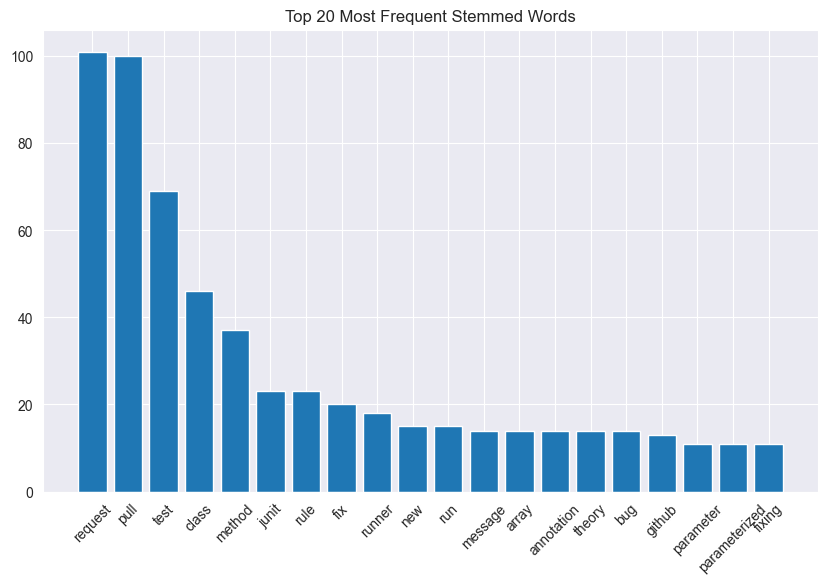

In [117]:
# Word frequencies
from collections import Counter
import matplotlib.pyplot as plt

all_stemmed_words = [word for tokens in data["Stemmed_Tokens"] for word in tokens]
stemmed_word_freq = Counter(all_stemmed_words)

most_common_stemmed_words = stemmed_word_freq.most_common(20)
words, counts = zip(*most_common_stemmed_words)

plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Stemmed Words")
plt.show()

In [118]:
# Dispersion Plots
import seaborn as sns

category_words = data.groupby('General Category')['Stemmed_Tokens'].apply(
    lambda tokens: [word for token_list in tokens for word in token_list]
)

category_word_freq = category_words.apply(Counter)

for category, freq in category_word_freq.items():
    most_common = dict(freq.most_common(10))

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(most_common.keys()), y=list(most_common.values()))
    file_name = category.replace(" ", "_")
    plt.title(f"Top Words in Category: {category}")
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.savefig(f"../resources/diagrams/top_words_{file_name}.png", format='png')
    plt.close()


### JUST A TEST

In [119]:
joblib.dump(classifier, "classifier_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")

# Load the saved models
loaded_classifier = joblib.load("classifier_model.pkl")
loaded_vectorizer = joblib.load("vectorizer.pkl")

# Predict on new data
new_text = [
    "Source has been split into directories src/main/java and src/test/java, making it easier to exclude tests from builds, and making JUnit more maven-friendly"]
new_vector = loaded_vectorizer.transform(new_text)
prediction = loaded_classifier.predict(new_vector)

print("Predicted Category:", label_encoder.inverse_transform(prediction))


Predicted Category: ['Code redesign']
